In [1]:
import glob
import numpy as np
import pandas as pd 
from collections import defaultdict
from math import isclose
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_197909/3363862842.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [2]:
runs = glob.glob('/home/gabriel/WORKS/TrueNets/TrueBS/results/results_rebuttal/napoli/*/*/*/*/*/*/')

results = []
for r in runs[:]:
    max_angles = []
    min_distances = []
    prefix, subpath = r.split('results_rebuttal')
    params =  subpath.split('/')
    sa, rf, k, ratio, dens = params[3:-1]
    bp = prefix+'results_rebuttal'+'/'.join(params[:4])
    invmat = np.load(f'{bp}/inverse_translation_matrix.npy')
    viewsheds = np.load(f'{r}/viewsheds.npy')
    nodes = pd.read_csv(f'{r}/index.csv', 
                        sep=' ', 
                        header=0, 
                        names=['x', 'y', 'z', 'x_3003', 'y_3003', 'b', 'p_i']
                        ).set_index('p_i')
    links = np.argwhere(viewsheds) #get ones from the viewshed
    nodes_dict = {}
    for n in nodes.index:
        pn = nodes.loc[n]
        nodes_dict[n] = np.array([pn.x, pn.y])

    #create a dict with a list of bs that sees a point
    adjdict = defaultdict(list)
    for l in links:
        ant = l[1]
        p = l[0]
        if ant in nodes.index:
            adjdict[p].append(nodes_dict[ant])

    for p in adjdict.keys():
        bs_loc = invmat[p]
        dists = []
        angles = []
        vectors = []
        for loc in adjdict[p]:
            v = loc-bs_loc
            vectors.append(v)
            dists.append(np.linalg.norm(v))
            angles.append(float(np.degrees(np.arctan2(v[0], v[1])))) #cast to int to avoid errors
        angles.sort()      
        angles.append(angles[0])  ##Trick to create a ring
        angles = np.array(angles) #convert to n[0], vector[1]umpy
        diffs = (angles[1:] - angles[:-1]) % 360  #modulo 360 to get positive  angles
        assert(isclose(sum(diffs),360) or isclose(sum(diffs),0))

        result = {}
        result['sa'] = sa
        if rf == 'r1' and k=='1':
            result['scoring'] = '1-CM'
        elif rf == 'r1' and k=='3':
            result['scoring'] = '3-CM'
        elif rf == 'rlc' and k=='3':
            result['scoring'] = '3-CG'
        elif rf == 'fi'  and k=='3':
            result['scoring'] = '3-CF'
        elif rf == 'r2' and k=='3':
            result['scoring'] = '3-CM2'
        
        result['ratio'] = float(ratio)
        result['dens'] =int(dens)
        result['max_angle'] = diffs.max()
        result['min_distance'] = np.array(dists).min(axis=0)
        result['ncov'] = len(adjdict[p])
        # result['vectors'] = vectors
        # result['angles'] = angles[:-1]

        results.append(result)

results = pd.DataFrame(results)
        

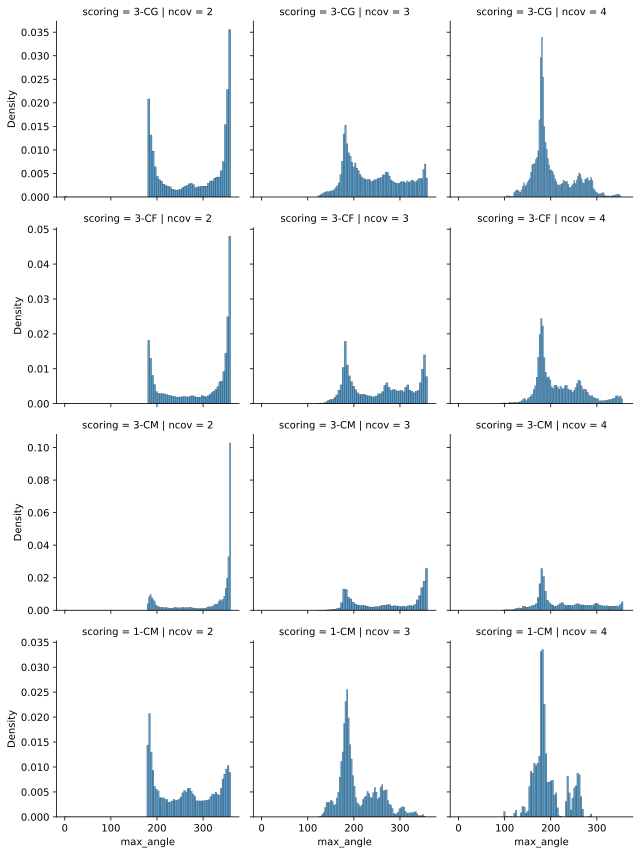

In [115]:

g = sns.FacetGrid(results[(results.ncov > 1) & (results.ncov <5) & (results.scoring != '3-CM2')], col="ncov",  row="scoring", sharey='row')
g.map_dataframe(sns.histplot, x='max_angle', stat='density')


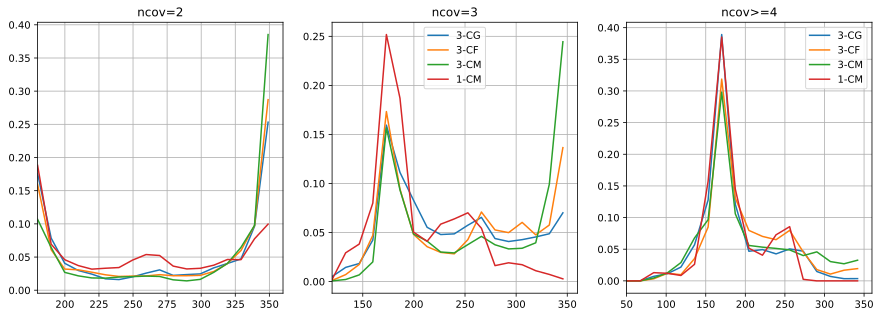

In [48]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
for score in results[(results.scoring != '3-CM2')].scoring.unique():
    vals = results[(results.ncov == 2) & (results.scoring == score)].max_angle
    y, bins = np.histogram(vals, bins=18, range=(180,359))
    y=y/sum(y)
    ax.plot(bins[:-1], y, label=score)
ax.set_xlim([180,360])
ax.set_yscale('linear')
ax.grid()
ax.set_title('ncov=2')

ax = plt.subplot(1,3,2)
for score in results[(results.scoring != '3-CM2')].scoring.unique():
    vals = results[(results.ncov == 3) & (results.scoring == score)].max_angle
    y, bins = np.histogram(vals, bins=18, range=(120,359))
    y=y/sum(y)
    ax.plot(bins[:-1], y, label=score)
ax.set_xlim([120,360])
ax.set_yscale('linear')
ax.legend()
ax.grid()
ax.set_title('ncov=3')

ax = plt.subplot(1,3,3)
for score in results[(results.scoring != '3-CM2')].scoring.unique():
    vals = results[(results.ncov > 3) & (results.scoring == score)].max_angle
    y, bins = np.histogram(vals, bins=18, range=(50,359))
    y=y/sum(y)
    ax.plot(bins[:-1], y, label=score)
ax.set_xlim([50,360])
ax.set_yscale('linear')
ax.legend()
ax.grid()
ax.set_title('ncov>=4')

plt.legend()


Text(0.5, 0, 'closest base station (meters)')

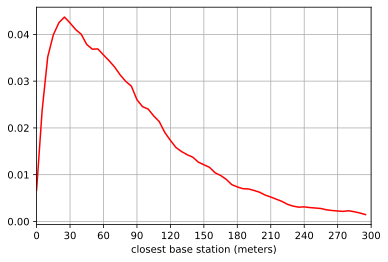

In [164]:
y, bins = np.histogram(results[(results.scoring != '3-CM2')].min_distance, bins=60, range=(0,300))
y=y/sum(y)
plt.plot(bins[:-1], y, 'r-')
plt.xticks(np.arange(0,330,30))
plt.xlim([0,300])
plt.grid()
plt.xlabel('closest base station (meters)')